# Python2 Notebook For Near-Infrared Image Eye Detection

In [9]:
%matplotlib inline
import os
import keras
import numpy as np 
import cv2
from matplotlib import pyplot
import sys

# 1. Set Repo Path

In [11]:
repo_root = './'
assert os.path.isdir( repo_root ), "ERROR: cannot locate code repo"
model_dir = os.path.join( repo_root, 'model' )
data_dir  = os.path.join( repo_root, 'data' )
lib_dir   = os.path.join( repo_root, 'lib')
sys.path.insert( 0, lib_dir )
import nirEyeDet

# 2. Prepare Model


| **Model File** | **#Resolution** | **Mirroring** | **Resizing** | **Rotation** | **#Params** | **Size** |
|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|
| `eyeGridDetector-a.h5` | Single | Yes | N/A | N/A | 465,905 | 1.9M |
| `eyeGridDetector-b.h5` | Single | Yes | (0.80, 1.25) | N/A |465,905 |1.9M |
| `eyeGridDetector-c.h5` | Single | Yes | (0.67, 1.50) | N/A |465,905 |1.9M |
| `eyeGridDetector-d.h5` | Single | Yes | (0.67, 1.50) | (-30,30) |465,905 |1.9M |
| `eyeMulResDetector.h5` | Multiple (4) | Yes | (0.67, 1.50) | (-30,30) | 843,124 | 3.3M |

## 2.1. Grid-Based Eye Detector

## Pros
1. Fast
2. Low Memory Requirement
3. Multiple available models can be used for ensemble prediction
4. No need to do any padding

## Cons
1. Grid-only, i.e. no pixel-level prediction
2. Some, but not much, resistance to the scale change

In [38]:
weight_file = os.path.join( model_dir, 'eyeGridDetector-b.h5')
grid_model = nirEyeDet.create_grid_model( initial_weights = weight_file )
print grid_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, None, None, 1)     0         
_________________________________________________________________
b1c1 (Conv2D)                (None, None, None, 16)    160       
_________________________________________________________________
b1c2 (Conv2D)                (None, None, None, 16)    272       
_________________________________________________________________
pool2 (MaxPooling2D)         (None, None, None, 16)    0         
_________________________________________________________________
b2c1 (Conv2D)                (None, None, None, 32)    4640      
_________________________________________________________________
b2c2 (Conv2D)                (None, None, None, 32)    1056      
_________________________________________________________________
pool3 (MaxPooling2D)         (None, None, None, 32)    0         
__________

## 2.2. Load multi-resolution eye detector

## Pros
1. Accurate and pixel-level prediction
2. Higher resistance to scale changes

## Cons
1. Require padding an image such that its dimensions are multiple of 16
2. Relatively slow

In [53]:
weight_file = os.path.join( model_dir, 'eyeMulResDetector.h5')
multi_res_model = nirEyeDet.create_multi_res_model( initial_weights = weight_file )
print multi_res_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img_in (InputLayer)              (None, None, None, 1) 0                                            
____________________________________________________________________________________________________
b1c1 (Conv2D)                    (None, None, None, 16 160         img_in[0][0]                     
____________________________________________________________________________________________________
b1c2 (Conv2D)                    (None, None, None, 16 272         b1c1[0][0]                       
____________________________________________________________________________________________________
pool2 (MaxPooling2D)             (None, None, None, 16 0           b1c2[0][0]                       
___________________________________________________________________________________________

# 3. Utils

## Tips for *resize_factor* selection:
## resize an input such that the eye diameter is about 16 pixels.


In [45]:
def predict_eye_location( model, image_file, resize_factor=1 ) :
    # 1. load image
    img = cv2.imread( image_file, 0 )
    # 2. resize it if necessary
    h, w = img.shape[:2]
    if ( resize_factor != 1 ) :
        nh = int( resize_factor * h )
        nw = int( resize_factor * w )
        simg = cv2.resize( img, (nw, nh) )
    else :
        simg = img
    # 3. convert to FCN input
    sh, sw = simg.shape[:2]
    if 'MulRes' in model.name :
        # force image size to be multiple of 16
        ph, pw = -sh%16, -sw%16
        simg = np.pad( simg, ((0,ph),(0,pw)), mode='constant')
        sh, sw = simg.shape[:2]
    x = simg.astype( np.float32 ) / 255.
    x = x.reshape([1,sh,sw,1])
    # 4. predict eye location
    y = model.predict( x )
    proba = y[0,...,0]
    return simg, proba

# 4. Sample Decoding Code

## 4.1. Decoding using the grid-based eye detector

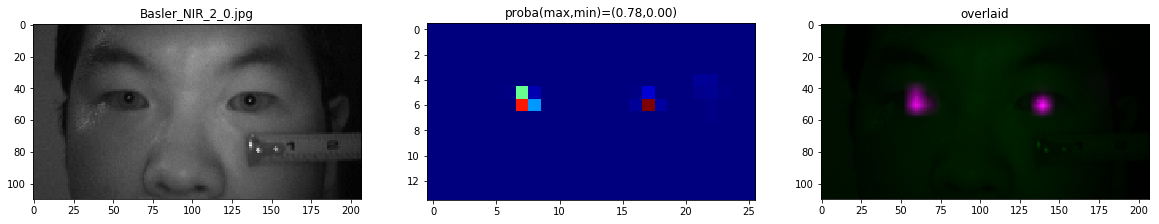

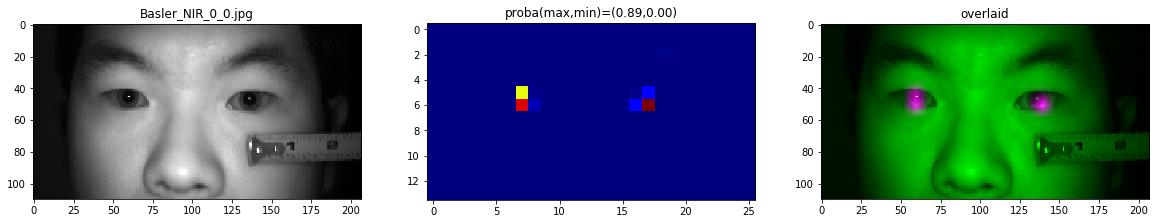

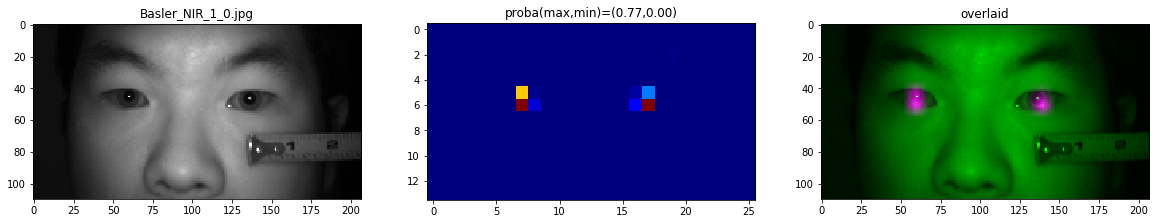

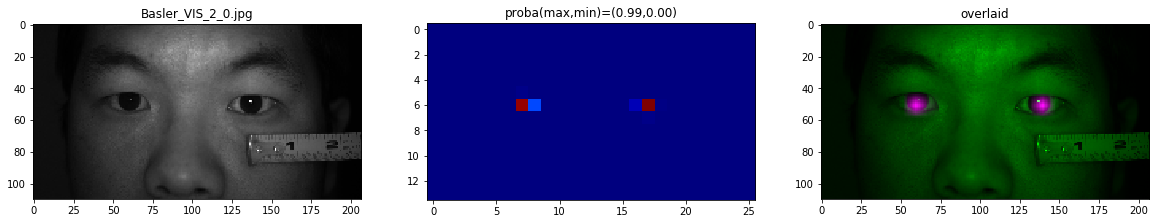

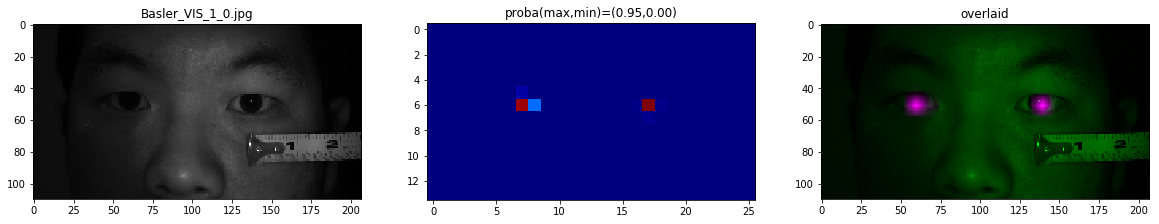

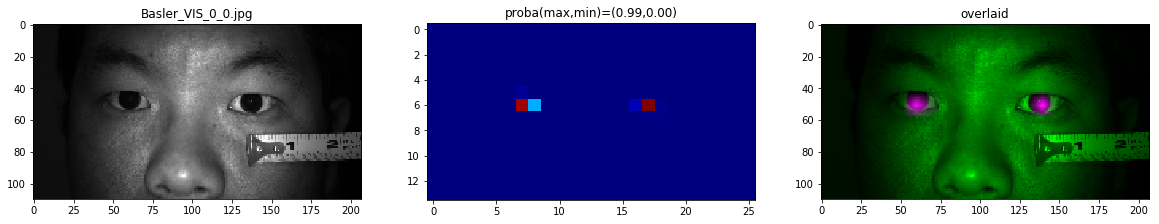

In [39]:
rf = 110./2168
for f in os.listdir( data_dir ) :
    if ( f.endswith('jpg')) :
        image_file = os.path.join( data_dir, f )
        img, proba = predict_eye_location( grid_model, image_file, resize_factor=rf )
        pyplot.figure( figsize=(20,30))
        pyplot.subplot(131)
        pyplot.imshow( img, cmap='gray')
        pyplot.title(f)
        pyplot.subplot(132)
        pyplot.imshow( proba, cmap='jet' )
        pyplot.title('proba(max,min)=({:.2f},{:.2f})'.format( proba.max(), proba.min()))
        pyplot.subplot(133)
        m = cv2.resize(proba, img.shape[::-1] ) 
        m = np.round( m/m.max() * 255 ).astype('uint8')
        pyplot.imshow( ( np.dstack( [ m, img, m] ) ) )
        pyplot.title('overlaid')

## 4.2. Decoding using the multi-resolution eye detector

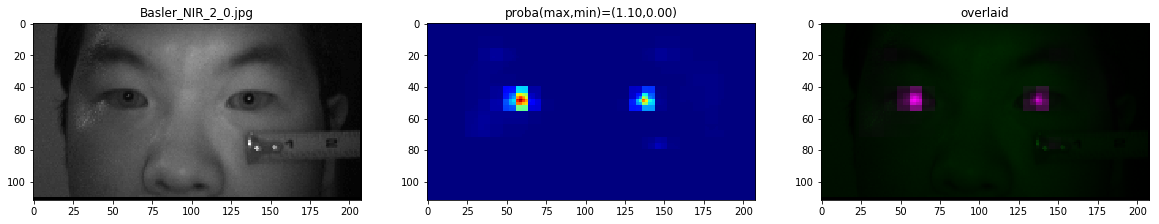

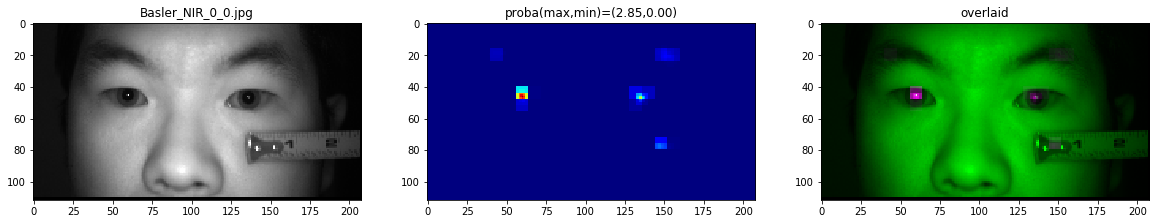

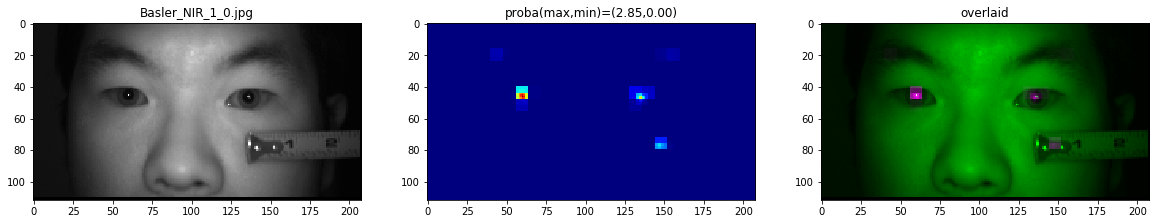

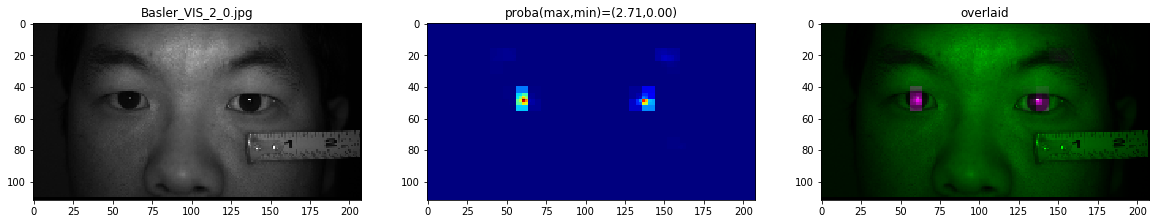

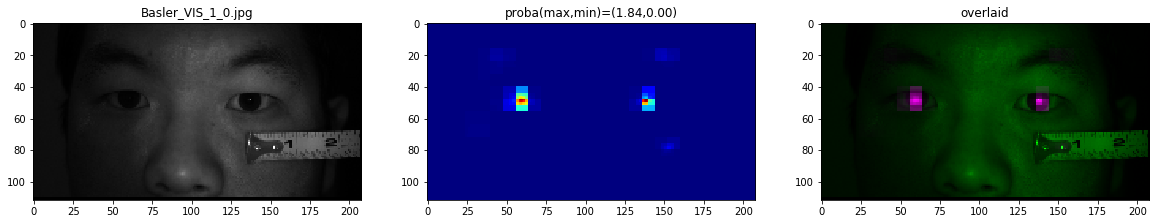

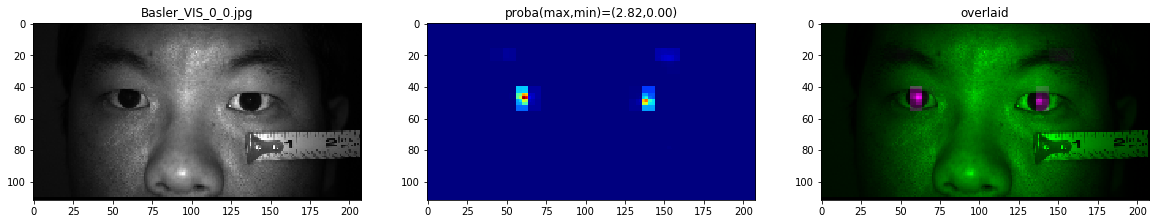

In [55]:
rf = 110./2168 # rule of thumb for resize factor (rf) is to make the eye in resulting image to be around 16x16
for f in os.listdir( data_dir ) :
    if ( f.endswith('jpg')) :
        image_file = os.path.join( data_dir, f )
        img, proba = predict_eye_location( multi_res_model, image_file, resize_factor=rf )
        pyplot.figure( figsize=(20,30))
        pyplot.subplot(131)
        pyplot.imshow( img, cmap='gray')
        pyplot.title(f)
        pyplot.subplot(132)
        pyplot.imshow( proba, cmap='jet' )
        pyplot.title('proba(max,min)=({:.2f},{:.2f})'.format( proba.max(), proba.min()))
        pyplot.subplot(133)
        m = cv2.resize(proba, img.shape[::-1] ) 
        m = np.round( m/m.max() * 255 ).astype('uint8')
        pyplot.imshow( ( np.dstack( [ m, img, m] ) ) )
        pyplot.title('overlaid')